
# The scope of this project is to familiarize with graph related techniques and apply them in multiple datasets.
Firstly, we want to test implemented and customized algorithms to karate club network in order to validate the results.
At the second phase we have identified 2 Use Cases to extract information for movies collection dataset.
In particular we want to:


1.   Connect Directors and Actors based on their collaboration and find cliques among them
2.   Connect Actors and Movies in weighted graph based on the revenue of the movie. In that way we can identify important nodes (Actors) that will eventually lead to a successful movie



In [0]:
from sklearn import cluster
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm,colors
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import scipy
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from numpy.linalg import inv
from numpy import linalg as LA
matplotlib_axes_logger.setLevel('ERROR')


Load and use karate club network
Link: [NetworkX karate club](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_karate_club.html
)

In [0]:
G = nx.karate_club_graph()
pos = nx.spring_layout(G)


In [0]:
def draw_communities(G, y_actual, pos, title):
    """
    Function responsible to draw the nodes to a plot with assigned colors for each individual cluster
    Inputs
    ----------
    G : networkx graph
    y_actual : list with the ground truth
    pos : positioning as a networkx spring layout
        E.g. nx.spring_layout(G)
    title : The title of the plot
    """ 
    fig, ax = plt.subplots(figsize=(16,9))
    
    # Convert y_actual list to a dict where key=cluster, value=list of nodes in the cluster
    key = defaultdict(list)
    for node, value in enumerate(y_actual):
        key[value].append(node)
    
    # Normalize number of clusters for choosing a color
    norm = colors.Normalize(vmin=0, vmax=len(key.keys()))
    
    for cluster, members in key.items():
        nx.draw_networkx_nodes(G, pos,
                               nodelist=members,
                               node_color=cm.jet(norm(cluster)),
                               node_size=500,
                               alpha=0.8,
                               ax=ax)

    # Draw edges (social connections) and show final plot
    plt.title(title)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax,edge_labels=labels)

In [0]:
# True labels of the group each student (node) unded up in. Found via the original paper
y_true = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

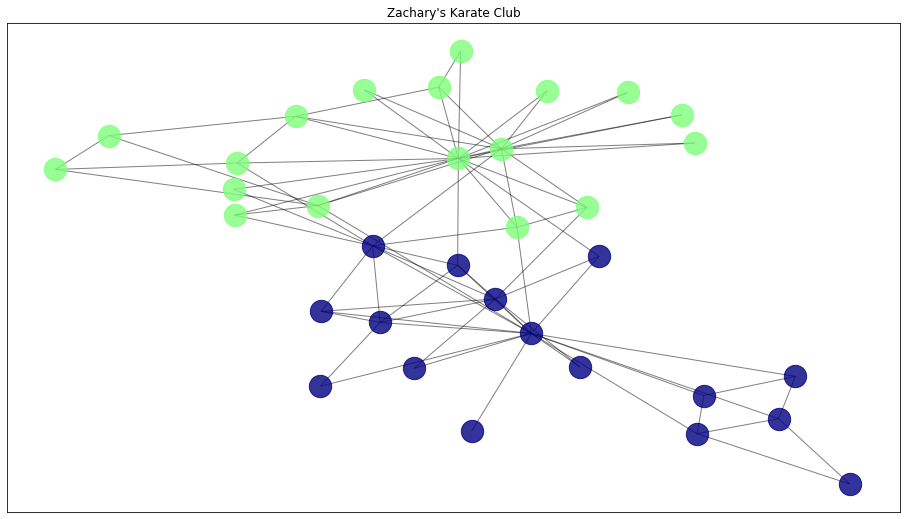

In [5]:
draw_communities(G, y_true, pos, "Zachary's Karate Club")

# Custom Implemented Algorithms

**In order to familiarize with Spectral Clustering we have implemented the original version**

In order to validate the validity of our implementation we compare the results with the sklearn SpectralClustering Results (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)

In [0]:
def laplacian(A):
    """
    Computes the symetric normalized laplacian.
    L = D^{-1/2} A D{-1/2}
    Inputs: 
    ----------
    A : Affinity or Adj matrix
    """
    D = np.zeros(A.shape)
    w = np.sum(A, axis=0)
    D.flat[::len(w) + 1] = w ** (-0.5)  # set the diag of D to w
    return D.dot(A).dot(D)

def k_means(X, n_clusters):
    """
    Computes KMeans clustering algorithm.
    Inputs: 
    ----------
    X : array-like or sparse matrix, shape=(n_samples, n_features)
    n_clusters : The number of clusters
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=1231)
    return kmeans.fit(X).labels_

def spectral_clustering(affinity, n_clusters, cluster_method=k_means):
    """
    Calculates Spectral Clustering
    Inputs: 
    ----------
    affinity : Affinity or Adj matrix
    n_clusters : The number of clusters
    cluster_method : Default usage of kMeans
    """
    L = laplacian(affinity)
    eig_val, eig_vect = scipy.sparse.linalg.eigs(L, n_clusters)
    X = eig_vect.real
    rows_norm = np.linalg.norm(X, axis=1, ord=2)
    Y = (X.T / rows_norm).T
    labels = cluster_method(Y, n_clusters)
    return labels

# RAM Spectral Clustering Algorithm via Simulated Mixing
(https://ieeexplore.ieee.org/document/8331142)

The current implementation is not full percent aligned with the pseudo-code written in the published article.

At the implementation we have faced many difficulties to understand the way the algorithm will work and how the results will be produced and returned from the function.

Specifically although the algorithm indicates on 2 Input variables:

*   M: The Similarity Matrix calculates as: (1-a)I + a * inv(D) * W
        where I is the Identity matrix, a is a custom variable with no further          input on its values range, D is the diagonal degree Matrix and W is the         weighted Matrix
*   e0: The initial tolerance

The Idea of the algorithm is to use Linear Algebra transformation with random created vectors in order to "mix" the nearest points and create clusters. The algorithm does not take as input the number of clusters k



In [0]:
def RAM(M, e, startingIndexes):
   # We are using 2 global variables in order to get the outcome of the algorithm
   # ram_cluster will take all the final produced clusters
   # startingM will be used to reinitilize the recursive procedure
   global ram_cluster
   global startingM
   n = M.shape[0]
   # b is another dynamic values that determines the way the cluster behaves
   # as it is used in order to decrease the tolerance we have defined. If it is 
   # the tolerance will quickly reach a state where it will terminate the execution
   b = 100
   x = np.random.uniform(0,b,n)
   e0 = e
   emin = 0.000001
   tmax = 400
   t = 0
   np.seterr(all='raise')
   while True:
      while True:
         if t == 0:
            xt = M.dot(x)
            yt1 = LA.norm(xt - x)
            t += 1
            continue
         # We create a vector simulating an eigenvector from the x random generated vector 
         # which we have calculated the dot product with the similarity Matrix
         x = xt
         yt = yt1
         xt = M.dot(x)
         yt1 = LA.norm(xt - x)
         t += 1
         try:
            difference = abs(yt1 - yt)
         except FloatingPointError:
            break
         if difference <= e0:
            break
      # Calculation of gap. If a positive gap is found it will be used to bipartite a graph
      gap = []
      sortedXt = np.sort(xt)
      for i in range(len(xt) -1):
         arg1 = sortedXt[i+1] - sortedXt[i]
         arg2 = b / (2 * n)
         if arg1 >= arg2:
            gap.append(arg1)
         else:
            gap.append(0)
      try:
         maxGap = np.amax(gap)
      except ValueError:  #raised if `gap` is empty or very small
         maxGap = 0
      if e0 <= emin or t >= tmax:
         print("The number of Iterations are to end the RAM algorithm were: " + str(t))
         return
      e0 = e0 / 2
      if maxGap > 0:
         break
   Mi1 = []
   Mi2 = []
   ind1 = []
   ind2 = []
   flag = 1
   # At this stage the algorithm has found a gap
   # After that we need to bipartite the graph based on the maximum value of gap vector
   # Although in order not to lose the indexing of the points and return their label
   # we have to keep track of the indices
   for val in range (0, len(xt) -1):
      # The article does not mention the exact steps to bipartite the graph
      # So we are using the maxGap / 2 in order to split the graph
      if abs(xt[val] - xt[val+1]) > maxGap / 2 and flag == 1:
         Mi1.append(xt[val])
         if len(startingIndexes) == 0:
            ind1.append(val)
         else:
            ind1.append(startingIndexes[val])
         flag = 2
      elif abs(xt[val] - xt[val+1]) > maxGap / 2 and flag == 2:
         Mi2.append(xt[val])
         if len(startingIndexes) == 0:
            ind2.append(val)
         else:
            ind2.append(startingIndexes[val])
         flag = 1
      else:
         if flag == 1:
            Mi1.append(xt[val])
            if len(startingIndexes) == 0:
               ind1.append(val)
            else:
               ind1.append(startingIndexes[val])
         elif flag == 2:
            Mi2.append(xt[val])
            if len(startingIndexes) == 0:
               ind2.append(val)
            else:
               ind2.append(startingIndexes[val])
   if flag == 1:
      Mi1.append(xt[val+1])
      if len(startingIndexes) == 0:
         ind1.append(val+1)
      else:
         ind1.append(startingIndexes[val+1])
   elif flag == 2:
      Mi2.append(xt[val+1])
      if len(startingIndexes) == 0:
         ind2.append(val+1)
      else:
         ind2.append(startingIndexes[val+1])
   #print("-----------------------------------------------------")
   #print("First Graph")
   #print(Mi1)
   #print("-----------------------------------------------------")
   #print("Second Graph")
   #print(Mi2)
   #print("-----------------------------------------------------")
   #print("Maximum Gap")
   #print(maxGap)
   # After we bipartite the graph we have to re-normalize the 2 splitted graphs
   # and continue the recursion. Though there aren't any steps for the re-normalization
   # of the graph. So in order to proceed we take a slice of the starting similarity matrix
   # based on the bipartite indexes we have calculated and start the recursion
   # The idea is that the random generated vectors will find further differences
   Mi1Final = np.zeros((len(Mi1),len(Mi1)))
   Mi2Final = np.zeros((len(Mi2),len(Mi2)))
   for i in range(len(Mi1)-1):
      for j in range(len(Mi1)-1):
         Mi1Final[i][j] = startingM[ind1[i]][ind1[j]]
   for i in range(len(Mi2)-1):
      for j in range(len(Mi2)-1):
         Mi2Final[i][j] = startingM[ind2[i]][ind2[j]]
   #row_sums = Mi1Final.sum(axis=1)
   #Mi1Final = Mi1Final / row_sums[:, np.newaxis]
   #row_sums = Mi2Final.sum(axis=1)
   #Mi2Final = Mi2Final / row_sums[:, np.newaxis]
   C = RAM(np.asarray(Mi1Final), e,ind1)
   if C is None:
      ram_cluster.append(ind1)
   C = RAM(np.asarray(Mi2Final), e,ind2)
   if C is None:
      ram_cluster.append(ind2)
   return ram_cluster

# RAM SHOWCASE

A Small Example of how RAM algorithm works can be seen in the following example:

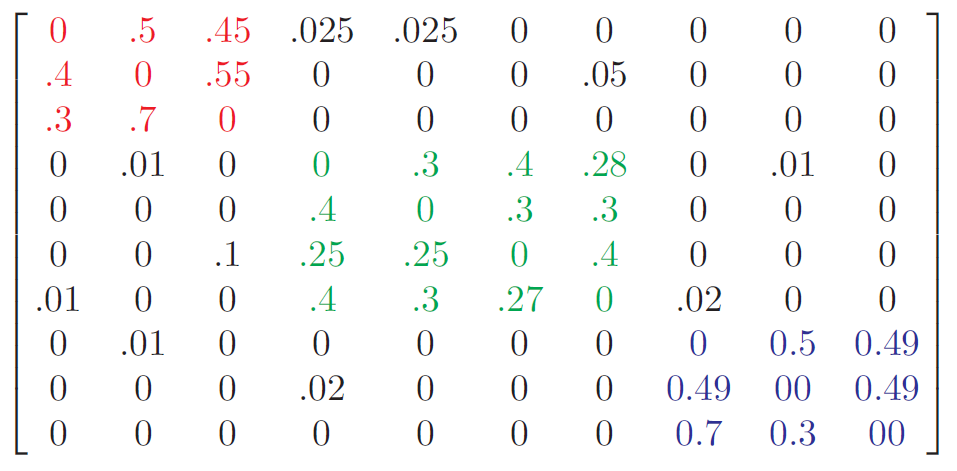

The above array has defined 3 Clusters 
This Array is our Similarity matrix

In [59]:
# We load the same matrix from a csv file
#from google.colab import files
#uploaded = files.upload()

#RAM_sample_M = pd.read_csv("ram_sample.csv", header=None)
#RAM_sample_M = RAM_sample_M.to_numpy()
startingM = RAM_sample_M
ram_cluster = []
e=0.1
RAM_sample_results = RAM(RAM_sample_M,e,[])
RAM_sample_results

-----------------------------------------------------
First Graph
[42.51841946355438, 42.57619260739781, 42.73456358868228, 34.86674748992853, 34.90125475097499, 35.52838712457603, 34.66465887279303]
-----------------------------------------------------
Second Graph
[16.563291110764947, 16.635282138172435, 16.364617255114812]
-----------------------------------------------------
Maximum Gap
18.02937673462059
-----------------------------------------------------
First Graph
[41.181210671768895, 41.134351753136436, 42.460390559966626]
-----------------------------------------------------
Second Graph
[4.455219717782987, 3.9637219652830202, 6.619468671330714, 0.0]
-----------------------------------------------------
Maximum Gap
34.51488308180572
The number of Iterations are to end the RAM algorithm were: 27
The number of Iterations are to end the RAM algorithm were: 37
The number of Iterations are to end the RAM algorithm were: 28


[[0, 1, 2], [3, 4, 5, 6], [7, 8, 9]]

In the above results we can identify the steps of the algorithm and the procedure it follows:

1.   At the first recursion a bipartition of the graph happened based on the largest gap
2.   The Largest Gap is defined as 18. We will use the gap/2 so we will do our checks with gap = 9
3.   If we Imagine the outcome vector is the concatenation of First and Second Graph. By going through it and check with the gap the indexes i and i+1 we will conclude with that represenation
4.   The first graph having 7 elements will go through the recursion first. The second recursion will bipartite the graph again and split it to one matrix with 3 elements and the other with 4
5.   The recursion will continue for all the remaining matrixes and end with no results so we will get the clusters [[0, 1, 2], [3, 4, 5, 6], [7, 8, 9]] which is aligned to the ground truth



# Custom Functions to create different type of Matrixes

**We have created custom functions in order to calculate and use multiple matrixes like:**


1.   Adj Matrix
2.   Degree Matrix
3.   Weighted Matrix



In [0]:
def graph_to_weighted(G):
    """
    Convert a networkx graph into a weighted matrix.
    Inputs: 
    ----------
    G : networkx graph
    """
    # Initialize weighted matrix with zeros
    weighted_mat = np.zeros((len(G), len(G)), dtype=int)
    
    for node in G:
        for neighbor in G.neighbors(node):
            try:
              weighted_mat[node][neighbor] = G[node][neighbor]['weight']
            except KeyError:
              weighted_mat[node][neighbor] = G[neighbor][node]['weight']
        weighted_mat[node][node] = 0

    return weighted_mat

In [0]:
def graph_to_degree_matrix(G):
    """
    Convert a networkx graph into an degree matrix.
    Inputs: 
    ----------
    G : networkx graph
    """
    # Initialize degree matrix with zeros
    degree_mat = np.zeros((len(G), len(G)), dtype=int)
    
    for node in G:
        for neighbor in G.neighbors(node):
            degree_mat[node][neighbor] = 0
        degree_mat[node][node] = G.degree[node]

    return degree_mat

In [0]:
def graph_to_adj_matrix(G):
    """
    Convert a networkx graph into an adj matrix.
    Inputs: 
    ----------
    G : networkx graph
    """
    # Initialize adj matrix with zeros
    adj_mat = np.zeros((len(G), len(G)), dtype=int)
    
    for node in G:
        for neighbor in G.neighbors(node):
            adj_mat[node][neighbor] = 1
        adj_mat[node][node] = 1

    return adj_mat

In [27]:
ram_cluster = []
D = graph_to_degree_matrix(G)
n = D.shape[0]
I = np.identity(n)
a = 1
e = 0.1

# The RAM algorithm needs to have a weighted graph so we have created a sample of weights
# We faced many difficulties with this dataset we couldn't end up with 2 clusters and 
# a floating error was occured in RAM algorithm with a wrong calculation most likely
G.add_weighted_edges_from([(0,1,4.0), (0,2,5.0), (0,3,3.0), (0,4,3.0), (0,5,3.0), (0,6,3.0), (0,7,2.0), (1,2,6.0), (1,3,3.0), (1,7,4.0), (2,3,3.0), (2,7,4.0), (3,7,3.0), (4,6,2.0), (5,6,5.0), (8,0,2.0), (8,2,5.0), (9,2,1.0), (10,0,2.0), (10,4,3.0), (10,5,3.0), (11,0,3.0), (12,0,1.0), (12,3,3.0), (13,0,3.0), (13,1,5.0), (13,2,3.0), (13,3,3.0), (13,33,3.0), (14,32,3.0), (14,33,2.0), (15,32,3.0), (15,33,4.0), (16,5,3.0), (16,6,3.0), (17,0,2.0), (17,1,1.0), (18,32,1.0), (18,33,2.0), (19,0,2.0), (19,1,2.0), (19,33,1.0), (21,0,2.0), (21,1,2.0), (23,25,5.0), (23,27,4.0), (25,24,2.0), (27,2,2.0), (27,24,3.0), (28,2,2.0), (29,23,3.0), (29,26,4.0), (30,1,2.0), (30,32,3.0), (30,33,3.0), (30,8,3.0), (31,0,2.0), (31,24,2.0), (31,25,7.0), (31,28,2.0), (31,32,4.0), (31,33,4.0), (32,20,3.0), (32,2,2.0), (32,22,2.0), (32,23,5.0), (32,29,4.0), (32,33,5.0), (32,8,3.0), (33,20,1.0), (33,22,3.0), (33,23,4.0), (33,26,2.0), (33,27,4.0), (33,28,2.0), (33,29,2.0), (33,8,4.0), (33,9,2.0)])
W = graph_to_weighted(G)
M = (1-a) * I + a * inv(D).dot(W)
startingM = M
C= RAM(M,e,[])
indexes = []
for i in range(int(len(C)/2)):
  indexes = indexes + C[i]

ram_results = np.zeros(len(y_true),dtype=int)
for i in range(len(y_true)-1):
  if i in indexes:
    ram_results[i] = 0
  else:
    ram_results[i] = 1
print(C)
ram_results

4.0
The number of Iterations are to end the RAM algorithm were: 440
The number of Iterations are to end the RAM algorithm were: 1372
The number of Iterations are to end the RAM algorithm were: 766
[[0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13], [7, 9, 14, 15, 23, 25, 28, 30], [16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 29, 31, 32, 33]]


array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

# **Train and Fit Sklearn SC and our implementation**

Here we train, fit and draw the graphs we have created using the Clustering algorithms

In [0]:
k_clusters = 2
sc = cluster.SpectralClustering(n_clusters=k_clusters, affinity="precomputed", n_init=200)
adj_mat = graph_to_adj_matrix(G)
results = sc.fit(adj_mat)

custom_SC_results = spectral_clustering(adj_mat, k_clusters)

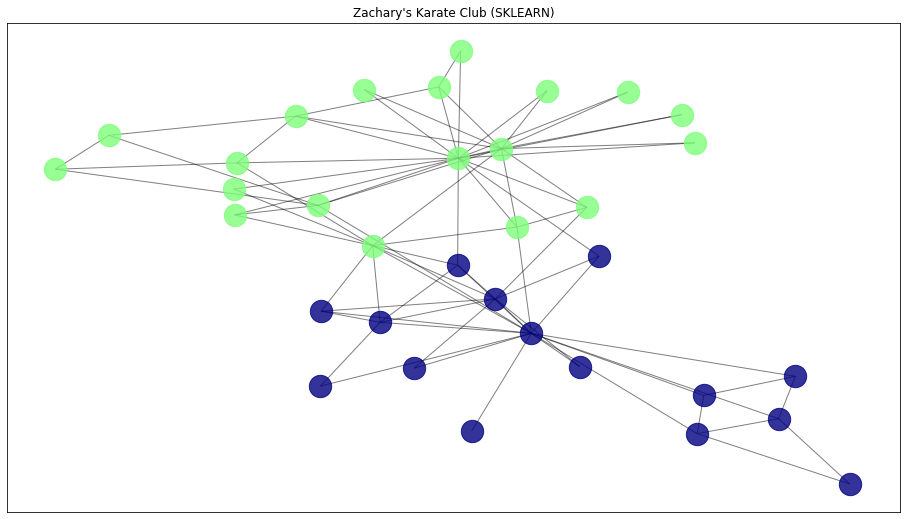

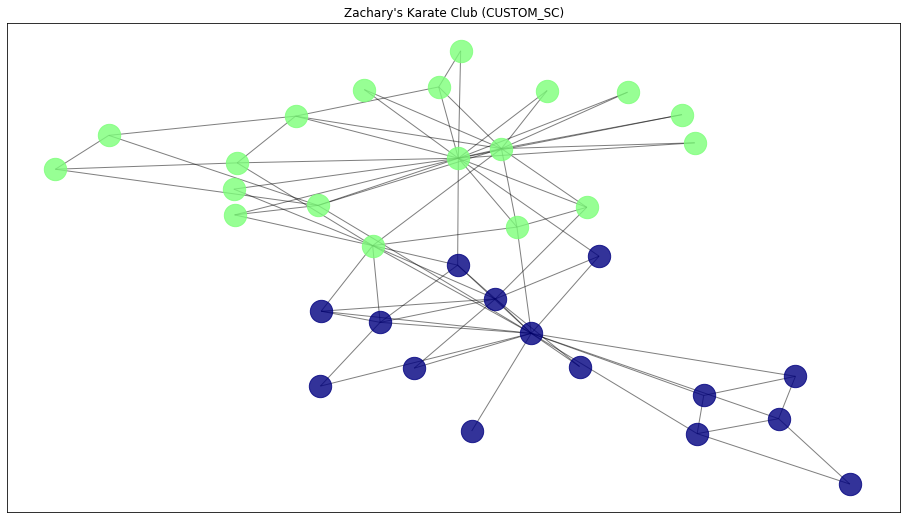

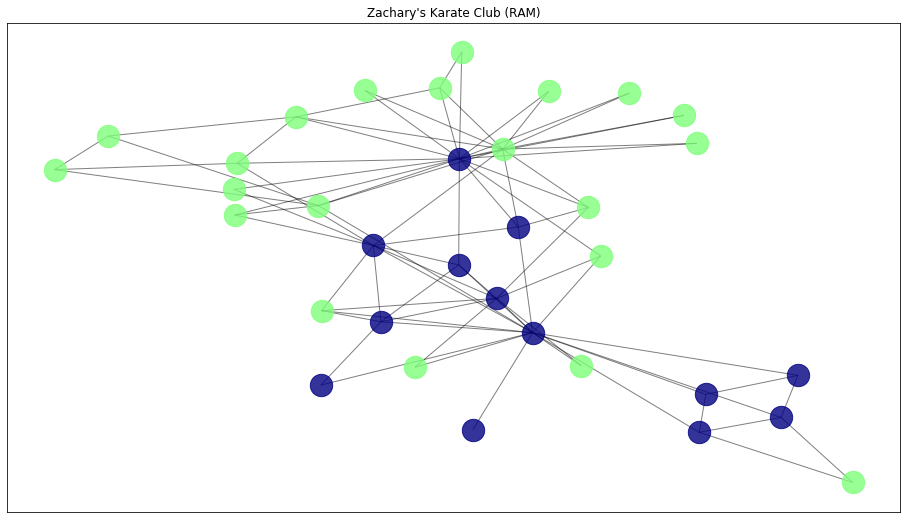

In [61]:
draw_communities(G, results.labels_, pos, "Zachary's Karate Club (SKLEARN)")
draw_communities(G, custom_SC_results, pos, "Zachary's Karate Club (CUSTOM_SC)")
draw_communities(G, ram_results, pos, "Zachary's Karate Club (RAM)")

# Metrics

For the metrics we have used:


*   normalized mutual information (NMI) = 
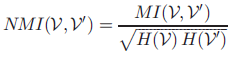
*   Adjusted Rand Score: The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. 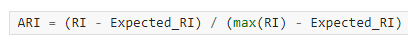



In [62]:
nmi_results = []
ars_results = []
y_true

y_true_val = list(y_true)

# Append the results into lists
nmi_results.append(normalized_mutual_info_score(y_true_val, results.labels_))
ars_results.append(adjusted_rand_score(y_true_val, results.labels_))
nmi_results.append(normalized_mutual_info_score(y_true_val, custom_SC_results))
ars_results.append(adjusted_rand_score(y_true_val, custom_SC_results))
nmi_results.append(normalized_mutual_info_score(y_true_val, ram_results))
ars_results.append(adjusted_rand_score(y_true_val, ram_results))
print("NMI: " + str(nmi_results))
print("ARS: " + str(ars_results))

NMI: [0.8364981174679549, 0.8364981174679549, 0.2775316016760354]
ARS: [0.882302454654689, 0.882302454654689, 0.3266845744984854]


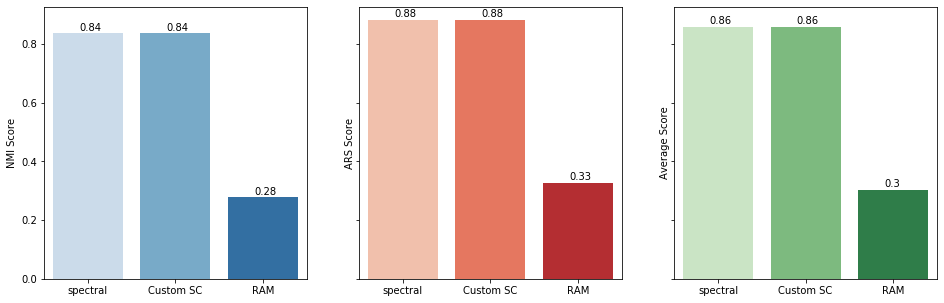

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 5))

x = np.arange(3)
avg = [sum(x) / 2 for x in zip(nmi_results, ars_results)]

xlabels = list(['spectral','Custom SC','RAM'])

sns.barplot(x, nmi_results, palette='Blues', ax=ax1)
sns.barplot(x, ars_results, palette='Reds', ax=ax2)
sns.barplot(x, avg, palette='Greens', ax=ax3)

ax1.set_ylabel('NMI Score')
ax2.set_ylabel('ARS Score')
ax3.set_ylabel('Average Score')

# # Add the xlabels to the chart
ax1.set_xticklabels(xlabels)
ax2.set_xticklabels(xlabels)
ax3.set_xticklabels(xlabels)

# Add the actual value on top of each bar
for i, v in enumerate(zip(nmi_results, ars_results, avg)):
    ax1.text(i - 0.1, v[0] + 0.01, str(round(v[0], 2)))
    ax2.text(i - 0.1, v[1] + 0.01, str(round(v[1], 2)))
    ax3.text(i - 0.1, v[2] + 0.01, str(round(v[2], 2)))

# Show the final plot
plt.show()


# RESULTS

**From the results we can determine the outcome of both of the algorithms that we have created**

The Custom SC has scored exactly the same with  the SKLEARN so the implemenation was accurate.

From the other hand there were many problems in the RAM algorithm that let the outcome be very low. Although we can see in the last figure that he tried in a way to identify a third cluster inside the 2 large ones by observing the missed nodes

In [0]:
def draw_true_vs_pred(G, y_true, y_pred, pos, algo_name, ax):
    

    for val in range(len(y_true)):
        if y_pred is not None:
            if y_true[val] == y_pred[val]:
                node_color = [0, 1, 0]
                node_shape = 'o'
            else:
                node_color = [0, 0, 0]
                node_shape = 'X'
       
        nx.draw_networkx_nodes(G, pos,
                               nodelist=[val],
                               node_color=node_color,
                               node_size=250,
                               alpha=0.7,
                               ax=ax,
                               node_shape=node_shape)
    
    # Draw edges and show final plot
    ax.set_title(algo_name)
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

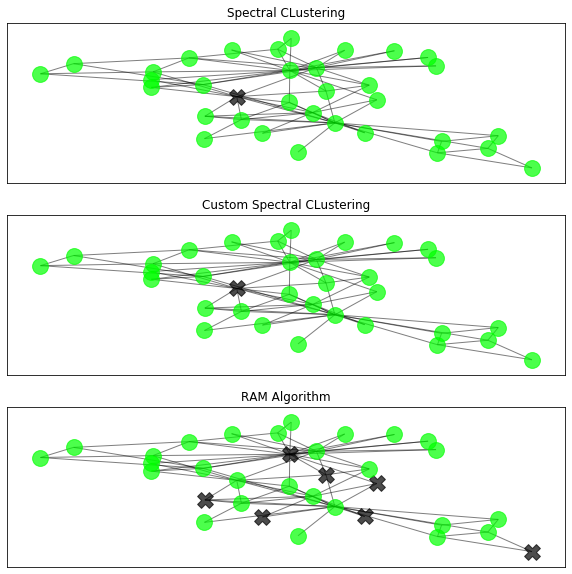

In [52]:
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(10, 10))
draw_true_vs_pred(G, y_true, results.labels_, pos, 'Spectral CLustering', ax1)
draw_true_vs_pred(G, y_true, custom_SC_results, pos, 'Custom Spectral CLustering', ax2)
draw_true_vs_pred(G, y_true, ram_results, pos, 'RAM Algorithm', ax3)